For complex tasks, a single agent can struggle. A task like "Research the latest AI advancements and write a blog post" requires multiple skills: searching, reading, synthesizing, and writing. The supervisor pattern addresses this by creating a team of specialized "worker" agents managed by one "supervisor" agent.

<ol><li>Supervisor: A "project manager" LLM that breaks down a complex request and delegates sub-tasks to the best worker for the job.</li>

<li>Workers: Specialized agents (or even simple, tool-using nodes) that are experts in one area, like searching the web or writing code.</li></ol>

**flow is loop**: The supervisor analyzes the state and routes to a worker. The worker completes its task, returns its findings to the state, and the flow returns to the supervisor to decide the next step.

In [1]:
from typing import TypedDict, Annotated, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langgraph.graph.message import add_messages

class TeamState(TypedDict):
    """State for the team agent."""
    messages : Annotated[list[BaseMessage],add_messages]
    next_worker: Optional[str] = None

Researcher and Writer

In [39]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
import os
from dotenv import load_dotenv
load_dotenv()
search_tool= TavilySearchResults(max_results=2)
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.2,
    google_api_key=os.getenv("GOOGLE_API_KEY"),
)
def reseracher_node(state:TeamState):
    """Resaercher node to search for information."""
    print("Researcher node called")
    
    print(state['messages'][-1].content)
    query = state['messages'][-1].content
    results= search_tool.invoke(query, max_results=2)
    return {"messages": HumanMessage(content=results, name="researcher")}

def write_node(state:TeamState):
    """Write node for generated content."""
    print("writer node")
    response = model.invoke(state['messages'])
    return {"messages": [response]}

workers={"reseracher": reseracher_node, "writer": write_node}

**Manager**<br>
 It's an LLM-powered node whose job is to look at the conversation and choose the next worker, or decide to finish

In [40]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """You are a supervisor of a team of AI workers. Given the following user request,
        respond with the name of the worker that should act next. Each worker will perform their
        task and return their results and status. When the user's request is fully satisfied,
        respond with the word FINISH.

        Available workers:
        - researcher: Use this worker to look up information on the web.
        - writer: Use this worker to write a final summary or response.

        Respond with the name of the worker, or FINISH."""),
        ("user", "{input}"),
        ("placeholder", "{messages}"),
    ]
)

supervisor_agent= supervisor_prompt | model | StrOutputParser()

def supervisor_node(state: TeamState):
    """Supervisor node for managing the team"""
    print("supervisor node called")
    response = supervisor_agent.invoke(
        input="run the team",
        messages=str(state['messages'])
    )
    
    if response == "FINISH":
        return {"next_worker": None}
    return {"next_worker": response}

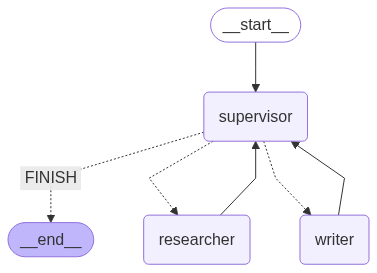

In [41]:
from langgraph.graph import StateGraph, END

team_graph=StateGraph(TeamState)

team_graph.add_node("researcher",reseracher_node)
team_graph.add_node("writer",write_node)
team_graph.add_node("supervisor", supervisor_node)

team_graph.set_entry_point("supervisor")
team_graph.add_conditional_edges(
    "supervisor", 
    lambda state: state['next_worker'],
{
    "researcher":"researcher",
    "writer":"writer",
    "FINISH": END
}
)
team_graph.add_edge("researcher","supervisor")
team_graph.add_edge("writer","supervisor")
graph=team_graph.compile()
graph



In [42]:
input_message="research about the latest advanvcement in NVIDIA"

response=graph.invoke(
    TeamState(messages=[HumanMessage(content=input_message)])
)
print(response)


supervisor node called
Researcher node called
research about the latest advanvcement in NVIDIA
supervisor node called
Researcher node called
[{'title': 'Research at NVIDIA | Advancing the Latest Technology', 'url': 'https://www.nvidia.com/en-us/research/', 'content': 'Have the latest news in groundbreaking NVIDIA Research sent directly to your inbox.\n\n## Get The Latest NVIDIA Research News\n\nNVIDIA Privacy Policy\n\n### NVIDIA Sionna\n\nSionna is a GPU-accelerated open-source library for physical-layer research and link-level simulations based on TensorFlow. It enables rapid prototyping of complex communication system architectures and provides native support for the integration of neural networks.  \n Sionna ›\n\n### NVIDIA Kaolin [...] NVIDIA Research is passionate about developing the technology and finding the breakthroughs that bring positive change to the world. Beyond publishing our work in papers and at conferences, we apply it to NVIDIA solutions and services, share resourc

ValidationError: 1 validation error for TavilyInput
  Input should be a valid dictionary or instance of TavilyInput [type=model_type, input_value=[{'title': 'Research at N...', 'score': 0.51105833}], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type